# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# HOMEWORK 1 - Supervised Deep Learning - Notebook 2/2

**FRANCESCO FONTANA -  matricola 2026924**



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import tqdm
import csv
from scipy.stats import loguniform
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os

In [ ]:
#Creating directory for storing images and graphs
if os.path.isdir("class_images")== False:
  os.mkdir("class_images")
if os.path.isdir("report")== False:
  os.mkdir("report")

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

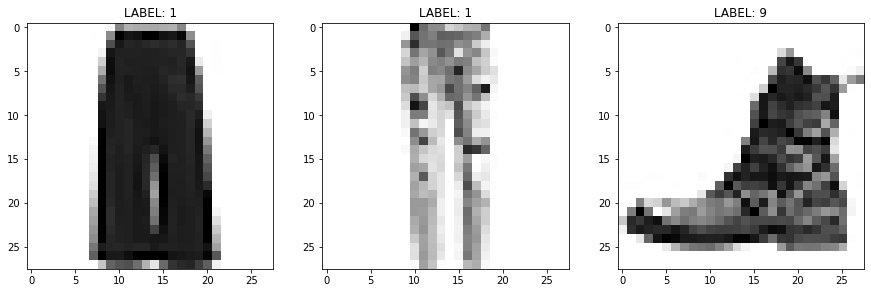

In [ ]:
#sample_index = range(4)
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i,sample_index in enumerate(np.random.choice(300,3)):
  image = train_dataset[sample_index][0]
  label = train_dataset[sample_index][1]

#  fig, ax = plt.figure(figsize=(5,5))
  ax[i].imshow(image, cmap='Greys')
  ax[i].set_title(f"LABEL: {label}")

plt.show()  
fig.savefig("report/example_images.pdf".format(sample_index), transparent = True, bbox_inches = 'tight', pad_inches = 0)


In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [ ]:
class Net(nn.Module):

    def __init__(self, dropout_conv=0):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)  # IN--> 1 x (28x28)  OUT--> 32 x (24x24)

        self.max_pool = nn.MaxPool2d(kernel_size=2)   # IN--> 32 x (24x24)  OUT--> 32 x (12x12)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5) # IN--> 32 x (12x12)  OUT--> 64 x (8x8)

        self.max_pool = nn.MaxPool2d(kernel_size=2)   # IN--> 64 x (8x8)  OUT--> 64 x (4x4) (flatten = 1024)

        self.fc1 = nn.Linear(1024, 128)   # IN--> 1 x (1024)  OUT--> 1 x (128)

        self.fc2 = nn.Linear(128, 10)     # IN--> 1 x (128)  OUT--> 1 x (10)
        
        self.act = nn.ReLU()
        self.dropout_conv = nn.Dropout(dropout_conv)
  

    def forward(self, x, stop1 = False, stop2 = False, stop3 = False):
        x = self.conv1(x)
        x = self.act(x)
        if stop1: return x
        x = self.max_pool(x)
        x = self.dropout_conv(x)
        
        x = self.conv2(x)
        x = self.act(x)
        if stop2: return x

        x = self.max_pool(x)
        x = self.dropout_conv(x)

        x = x.flatten() #.view(-1, 1024)
    
        x = self.fc1(x)
        x = self.act(x)
        if stop3: return x
        
        x = self.dropout_conv(x)
        
        x = self.fc2(x)

        return x

In [ ]:
class img_dataset(torch.utils.data.Dataset):
   
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:     
            x = self.transform(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
            
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset) 

In [ ]:
composed_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5,), (0.5,))
                                         ])

#---Train/Validation split---#

train_dataset = img_dataset(train_dataset, transform=composed_transform)
test_dataset = img_dataset(test_dataset, transform=composed_transform)

In [ ]:
def train_epoch(net, train_dataloader, loss_fn, optimizer):
    train_loss = []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")

In [ ]:
def test_epoch(net, val_dataloader, loss_fn):
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    return np.mean(val_loss)

In [ ]:
def random_hyperparameters():

    regularization_type = np.random.choice(['none', 'l2',])
    regularization_strength = 0.
    
    if regularization_type == 'l2': regularization_strength = loguniform.rvs(1e-5, 1e-1)
    elif regularization_type == 'dropout': regularization_strength = loguniform.rvs(1e-4, 1e-1)

    hyperparameters = {
        'n_epochs': 9,
        'batch_size': np.random.choice([64, 128, 256]).tolist(),
        'lr': loguniform.rvs(1e-4, 1e-1),
        'regularization_type' : regularization_type,
        'regularization_strength' : regularization_strength,
        'l2': regularization_strength if regularization_type == 'l2' else 0.,
        'dropout': np.random.choice([loguniform.rvs(1e-4, 1e-1), 0.], p=[0.4, 0.6]) ,
        'opt' : np.random.choice(['Adam', 'RMSprop', 'SGD'])
    }
    return hyperparameters

In [ ]:
def training_loop(train_dataset, params):
    # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    print(f"Training device: {device}")
    net = Net(dropout_conv=params['dropout'])
    net.to(device)

    
    num_epochs  = params["n_epochs"]
    tot_size = len(train_dataset)
    train_size = int(tot_size*0.8)
    val_size = tot_size - train_size

    train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_set, batch_size=params["batch_size"], shuffle=True)#, num_workers=2, pin_memory = True)
    val_dataloader  = DataLoader(val_set,  batch_size=len(val_set), shuffle=False)#, num_workers=2, pin_memory = True)
    
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Define the optimizer
    if params["opt"] == "Adam":      optimizer = optim.Adam(net.parameters(),    lr = params["lr"], weight_decay= params["l2"])
    elif params["opt"] == "RMSprop": optimizer = optim.RMSprop(net.parameters(), lr = params["lr"], weight_decay= params["l2"])
    elif params["opt"] == "SGD":     optimizer = optim.SGD(net.parameters(),     lr = params["lr"], weight_decay= params["l2"])
    
    train_loss_log = np.zeros(num_epochs)
    val_loss_log = np.zeros(num_epochs)
    
    
    for epoch_index in range(num_epochs):
            train_loss = train_epoch(net, train_dataloader, loss_fn, optimizer)
            train_loss_log[epoch_index] = train_loss

            val_loss = test_epoch(net, val_dataloader, loss_fn)
            val_loss_log[epoch_index] = val_loss


            print("\tEPOCH", epoch_index+1)
            print("\tTrain loss:", train_loss)
            print("\tVal loss:", val_loss)

#            # --- early stopping
#            if epoch_index >= 10:
#
#              cont=np.zeros(10)
#              for i, each_val in enumerate( val_loss_log[ (epoch_index-10) : epoch_index] ):
#                if val_loss_log[epoch_index] < each_val:
#                  cont[i] = 0 #True
#                else:
#                  cont[i] = 1 # False
#              if np.all (cont)== False:
#                break

            
    return train_loss_log, val_loss_log, net

In [ ]:
niter = 50
class_df = pd.DataFrame(columns = ["batch_size", "lr", "regularization_type", "regularization_strength", "l2", "dropout", "opt", "mean_train_loss", "mean_val_loss"], index = range(1,niter+1))

for it in range(1, niter+1):

    
    r_params = random_hyperparameters()
    class_df.loc[it] = r_params

    print("Random grid-search {}/{}".format(it,niter))

    loss, val, _ = training_loop(train_dataset, r_params)

    class_df.loc[it, "mean_train_loss"] = np.mean(loss, dtype = np.float32)
    class_df.loc[it, "mean_val_loss"] = np.mean(val, dtype = np.float32)

class_df

Random grid-search 1/50
Training device: cuda
	EPOCH 1
	Train loss: 0.7599497
	Val loss: 0.41692036
	EPOCH 2
	Train loss: 0.4067758
	Val loss: 0.39196858
	EPOCH 3
	Train loss: 0.35486543
	Val loss: 0.36357057
	EPOCH 4
	Train loss: 0.32357636
	Val loss: 0.38093507
	EPOCH 5
	Train loss: 0.3065027
	Val loss: 0.31579015
	EPOCH 6
	Train loss: 0.289302
	Val loss: 0.34065193
	EPOCH 7
	Train loss: 0.2789391
	Val loss: 0.32344404
	EPOCH 8
	Train loss: 0.2677831
	Val loss: 0.34543747
	EPOCH 9
	Train loss: 0.25898454
	Val loss: 0.34466672
Random grid-search 2/50
Training device: cuda
	EPOCH 1
	Train loss: 2.4438643
	Val loss: 2.3038113
	EPOCH 2
	Train loss: 2.3055587
	Val loss: 2.3038523
	EPOCH 3
	Train loss: 2.3058937
	Val loss: 2.304796
	EPOCH 4
	Train loss: 2.3054254
	Val loss: 2.306043
	EPOCH 5
	Train loss: 2.3062358
	Val loss: 2.3038583
	EPOCH 6
	Train loss: 2.3054438
	Val loss: 2.3041916
	EPOCH 7
	Train loss: 2.306027
	Val loss: 2.306967
	EPOCH 8
	Train loss: 2.305944
	Val loss: 2.3070707
	

,batch_size,lr,regularization_type,regularization_strength,l2,dropout,opt,mean_train_loss,mean_val_loss
1,64,0.003952,none,0.0,0.0,0.0,RMSprop,0.360742,0.358154
2,64,0.033207,none,0.0,0.0,0.0,Adam,2.321095,2.305001
3,128,0.001049,none,0.0,0.0,0.0,SGD,1.394363,1.308964
4,256,0.000287,l2,0.00443,0.00443,0.0,RMSprop,0.432882,0.410215
5,256,0.04498,none,0.0,0.0,0.0,RMSprop,274.357361,2.302902
6,128,0.000895,l2,0.000012,0.000012,0.0,Adam,0.277071,0.282836
7,64,0.072648,l2,0.000108,0.000108,0.0,Adam,3.362824,2.316813
8,128,0.006994,l2,0.000265,0.000265,0.0,SGD,0.713405,0.622664
9,64,0.019143,none,0.0,0.0,0.004217,SGD,0.444016,0.409673
10,256,0.087697,l2,0.006796,0.006796,0.0,RMSprop,3799.247314,2.362078


In [ ]:
class_df = class_df.astype({"mean_val_loss":float})

# ------ Saving dataframe random grid search ------
class_df.to_pickle("./random_grid_search_class.pkl")

# ------ Loading dataframe random grid search ------
class_df=pd.read_pickle("./random_grid_search_class.pkl")

best_res = class_df.nsmallest(10, 'mean_val_loss')
best_res

,batch_size,lr,regularization_type,regularization_strength,l2,dropout,opt,mean_train_loss,mean_val_loss
50,256,0.002019,none,0.0,0.0,0.001151,Adam,0.262057,0.281565
23,64,0.001336,none,0.0,0.0,0.0,Adam,0.229615,0.282089
6,128,0.000895,l2,0.000012,0.000012,0.0,Adam,0.277071,0.282836
11,128,0.000461,none,0.0,0.0,0.0,RMSprop,0.305803,0.304143
22,64,0.002189,l2,0.00002,0.00002,0.0,RMSprop,0.300103,0.308093
17,64,0.002862,none,0.0,0.0,0.001006,Adam,0.249072,0.314436
41,128,0.000421,l2,0.000867,0.000867,0.059512,Adam,0.354902,0.315774
42,64,0.059075,l2,0.000093,0.000093,0.0,SGD,0.325159,0.322073
21,256,0.00075,none,0.0,0.0,0.0,Adam,0.33141,0.328936
34,256,0.000649,none,0.0,0.0,0.018116,RMSprop,0.347954,0.338006


In [ ]:
hyperparameters = {
    'n_epochs': 100,
    'batch_size': 64,
    'lr': 0.0002,
    'l2': 0.0001,
    'opt': 'Adam',
    'dropout': 0.2
}

In [ ]:
final_loss_train, final_loss_val, net = training_loop(train_dataset, hyperparameters)

Training device: cuda
	EPOCH 1
	Train loss: 0.7995842
	Val loss: 0.51225734
	EPOCH 2
	Train loss: 0.5250913
	Val loss: 0.43405938
	EPOCH 3
	Train loss: 0.45876905
	Val loss: 0.39021227
	EPOCH 4
	Train loss: 0.4185333
	Val loss: 0.3574508
	EPOCH 5
	Train loss: 0.39191383
	Val loss: 0.33482936
	EPOCH 6
	Train loss: 0.36666015
	Val loss: 0.3267518
	EPOCH 7
	Train loss: 0.3511913
	Val loss: 0.3089616
	EPOCH 8
	Train loss: 0.33965054
	Val loss: 0.3018491
	EPOCH 9
	Train loss: 0.327574
	Val loss: 0.2942725
	EPOCH 10
	Train loss: 0.3183986
	Val loss: 0.2848428
	EPOCH 11
	Train loss: 0.30962855
	Val loss: 0.27617764
	EPOCH 12
	Train loss: 0.29758635
	Val loss: 0.27143702
	EPOCH 13
	Train loss: 0.2945103
	Val loss: 0.26986864
	EPOCH 14
	Train loss: 0.28875506
	Val loss: 0.26346478
	EPOCH 15
	Train loss: 0.28268424
	Val loss: 0.2620332
	EPOCH 16
	Train loss: 0.27441096
	Val loss: 0.2601181
	EPOCH 17
	Train loss: 0.2704801
	Val loss: 0.25526676
	EPOCH 18
	Train loss: 0.2639569
	Val loss: 0.251758

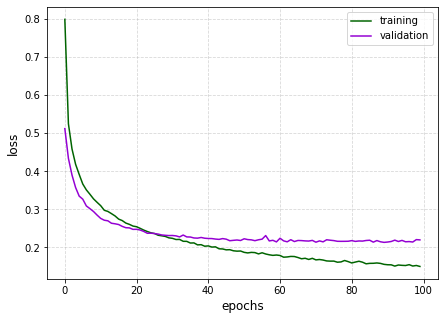

In [ ]:
#train_folds_mean = np.mean(train_folds, axis = 0)
#val_folds_mean = np.mean(val_folds, axis = 0)

size = 12
fig = plt.figure(figsize = (7,5))
plt.plot(final_loss_train, color = "darkgreen", label = "training")
plt.plot(final_loss_val, color = "darkviolet", label = "validation")
plt.xlabel("epochs", fontsize = size)
plt.ylabel("loss", fontsize = size)
#plt.legend(fontsize = size)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend()
plt.show()

fig.savefig("class_images/class_train.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
labels = []
outputs = []
net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        labels.append(label_batch)
        # Forward pass
        out = net(x_batch)
        outputs.append(out)
        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save test loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss = loss_batch

In [ ]:
outputs = torch.cat(outputs)
labels = torch.cat(labels)
outputs = outputs.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

predicted_labels = [outputs[i].argmax() for i in range(len(outputs))]
diffs = np.array([predicted_labels[i]-labels[i] for i in range(len(outputs))])
wrong = np.count_nonzero(diffs) 
test_accuracy = 1 - wrong/len(outputs)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.9218999999999999


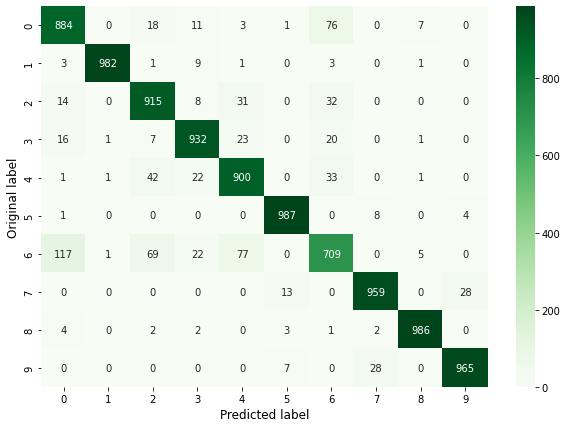

In [ ]:
### Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Evaluate confusion matrix
cm = confusion_matrix(labels, predicted_labels)
# Show the confusion matrix
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, cmap='Greens', fmt='d', annot=True)
plt.ylabel('Original label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.savefig('class_images/cmap.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()

## Plot hists and filters

In [ ]:
# First convolutional layer
conv1_w = net.conv1.weight.data.cpu().numpy() 
conv1_b = net.conv1.bias.data.cpu().numpy() 

# Second convolutional layer
conv2_w = net.conv2.weight.data.cpu().numpy()
conv2_b = net.conv2.bias.data.cpu().numpy() 

# First hidden layer
hid1_w = net.fc1.weight.data.cpu().numpy() 
hid1_b = net.fc1.bias.data.cpu().numpy() 

# Second hidden layer
hid2_w = net.fc2.weight.data.cpu().numpy()
hid2_b = net.fc2.bias.data.cpu().numpy()

In [ ]:
image_sample = DataLoader(test_dataset, batch_size=1, shuffle=True ) 
with torch.no_grad(): 
    for sample_batched in (image_sample):
        x_batch = sample_batched[0].to(device)
        out = net.forward(x_batch, stop1 = True)
        out = out.cpu().numpy()
        break

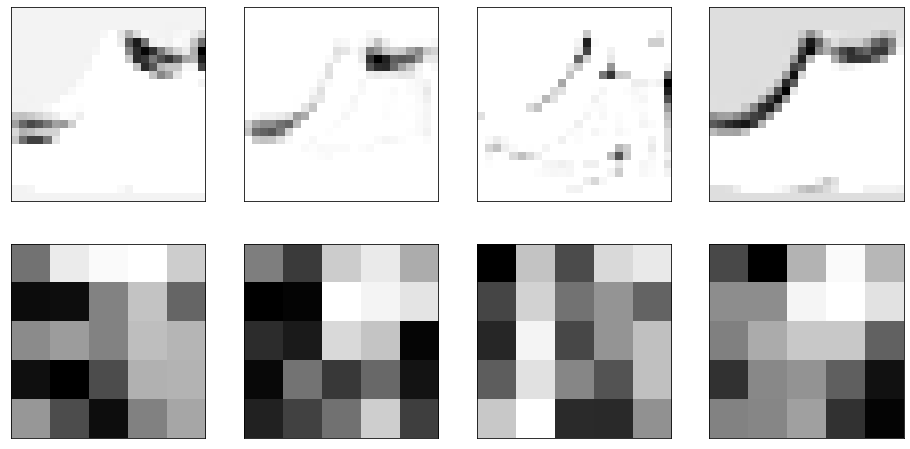

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs = axs.flatten()
n=4
for i in range(0, n):
    axs[i+n].imshow(conv1_w[i, 0, :, :], cmap='Greys')
    axs[i].imshow(out[0, i], cmap='Greys')
    axs[i+n].set_yticks([])
    axs[i+n].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
plt.show()
fig.savefig("class_images/kernel_visual.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)


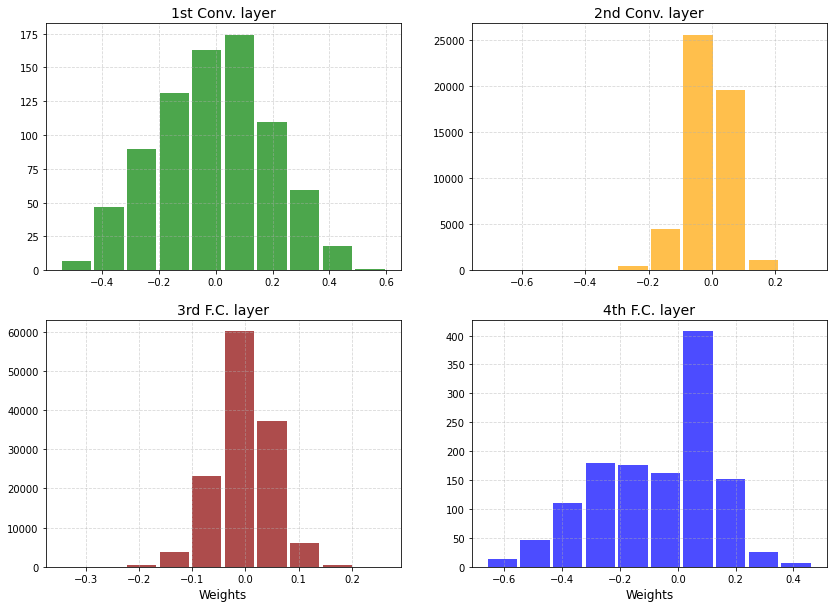

In [ ]:
from IPython.core.pylabtools import figsize

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14,10),)

#-----HISTOGRAM WEIGHT LAYER 1 -----
ax1.hist(conv1_w.flatten(), color = "green", fill = True, alpha = 0.7, rwidth=0.9)
#ax1.set_yticks(range(0,5))
ax1.set_title("1st Conv. layer", size = 14)

#-----HISTOGRAM WEIGHT LAYER 2 -----
ax2.hist(conv2_w.flatten(), color = "orange", fill = True, alpha = 0.7, rwidth=0.9,)
#ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.set_title("2nd Conv. layer", size = 14)

#-----HISTOGRAM WEIGHT LAYER 1 -----
ax3.hist(hid1_w.flatten(), color = "darkred", fill = True, alpha = 0.7,rwidth=0.9,)
#ax3.yaxis.set_minor_locator(MultipleLocator(5))
ax3.set_title("3rd F.C. layer", size = 14)
ax3.set_xlabel("Weights", size =12)

#-----HISTOGRAM WEIGHT LAYER 4 -----
ax4.hist(hid2_w.flatten(), color = "blue", fill = True, alpha = 0.7, rwidth=0.9,)
ax4.set_title("4th F.C. layer", size = 14)
ax4.set_xlabel("Weights", size =12)


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():

    #ax.label_outer()
    ax.grid( linestyle = "--",alpha=0.5)

fig.savefig("./report/all_hists_class.pdf", transparent = True, bbox_inches = "tight", pad_inches = 0)